In [1]:
!pip3 install git+https://github.com/nlpub/pymystem3

  Cloning https://github.com/nlpub/pymystem3 to /tmp/pip-req-build-tqh_jtui
  Running command git clone --filter=blob:none --quiet https://github.com/nlpub/pymystem3 /tmp/pip-req-build-tqh_jtui
  Resolved https://github.com/nlpub/pymystem3 to commit 5fcc151c7d80c5babd1a6f20e710f3ace81db98d
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import pandas as pd
import re

# Перевод обозначений различных частей речи в единные обозначения для Mystem и OpenCorpora

In [3]:
corpora_to_mystem = {'NOUN': 'S',
 'ADVB': 'ADV',
 'ADJF': 'A',
 'ADJS': 'A',
 'COMP': 'COM',
 'VERB': 'V',
 'INFN': 'V',
 'PRTF': 'V',
 'PRTS': 'V',
 'GRND': 'V',
 'CONJ':'CONJ',
 'INTJ': 'INTJ',
 'PRCL': 'PART',
 'PREP': 'PR',
 'PRED': 'ADV',
 'NUMR':'NUM',
 'NPRO': 'SPRO'}

mystem_to_mystem = {'APRO': 'A',
 'A': 'A',
 'CONJ':'CONJ',
 'PR':'PR',
 'S':'S',
 'V':'V',
 'ADV':'ADV',
 'PART':'PART',
 'SPRO':'SPRO',
 'ADVPRO':'ADV',
 'NUM':'NUM',
 'ANUM':'A',
 'INTJ':'INTJ',
 'COM':'COM'}

# Инициализация словаря в виде DataFrame
Использование DataFrame для хранения словаря и текстов является достаточно удобным способом работы из-за своей векторизации.
В ходе инициализации словаря опускаются омонимы по частям речи, так как, хоть морфоанализаторы и обладают встроенные методы разрешения омомонимии, но в рамках задачи проверяется частотность по частям речи, поэтому рассмотрение других характеристик лемм и словоформ кажется излишним(но не бесссмысленным)
Также многие авторы "брезгуют" использованием буквы "ё" (словоформа "ё" - "е"), то было принято решение заменить в словаре все "е" на "ё"

In [4]:
def load_WFdictionary(file_path):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            number_lemma = None
            for line in f:
                parts = line.strip().split()
                if len(parts) == 1:

                    try:
                        number_lemma = int(parts[0])
                    except ValueError:
                        print(f"Ошибка преобразования номера леммы: {parts[0]}")
                elif len(parts) > 1 and number_lemma is not None:

                    word = parts[0].lower().replace('ё', 'е')
                    features = parts[1].split(',')[0]

                    data.append({'№ Lemma': number_lemma, 'Word': word, 'Part of speech': features})
    except FileNotFoundError:
        print(f"Файл {file_path} не найден.")

    data = pd.DataFrame(data)
    data['Part of speech'] = data['Part of speech'].replace(corpora_to_mystem)
    data.drop_duplicates(['Word', 'Part of speech'], inplace=True, ignore_index=True)
    return data


dictionary = load_WFdictionary('/kaggle/input/text-files/dict.opcorpora.txt')

Интересный факт: заявленная в словаре нумерация лемм не особо корректная, на самом деле, лемм в словаре примерно на 4000 меньше, чем номер последней леммы

# Создание исключительно для лемм

In [5]:
def make_lemma_dictionary(dictionary):
    lemma_dictionary = dictionary.groupby('№ Lemma').head(1).reset_index(drop=True)
    lemma_dictionary.drop_duplicates(['Word','Part of speech'], ignore_index= True, inplace= True)
    return lemma_dictionary

lemma_dictionary = make_lemma_dictionary(dictionary)

# Создание DataFrame словоформ и лемм для исследуемых текстов

In [6]:
def analyze_text(text):
    mystem = Mystem()
    analysis_results = mystem.analyze(text)

    data = []
    for result in analysis_results:
        if isinstance(result, dict) and 'analysis' in result and result['analysis']:
            lemma = result['analysis'][0]['lex']
            part_of_speech = re.split(r'[=,]', result['analysis'][0]['gr'])[0].strip()
            word_form = result['text'].lower().replace('ё', 'е')
            data.append({'Word': word_form, 'Lemma': lemma, 'Part of speech': part_of_speech})

    data = pd.DataFrame(data)
    data['Part of speech'] = data['Part of speech'].replace(mystem_to_mystem)
    data.drop_duplicates(['Word', 'Part of speech'], inplace= True, ignore_index=True)
    return data

In [7]:
def analyze_missing_words_from_dict(analyzed_df, lemma_analyzed_df, threshold_percentage=5):
    
    missing_words = dictionary[~dictionary['Word'].isin(analyzed_df['Word'])]
    missing_lemmas = lemma_dictionary[~lemma_dictionary['Word'].isin(lemma_analyzed_df['Lemma'])]

    missing_count_words = missing_words.shape[0]
    
    missing_count_lemmas = missing_lemmas.shape[0]
    
    total_words_dict = dictionary.shape[0]
    total_lemmas_dict = lemma_dictionary['Word'].shape[0]

    missing_percentage_words = (missing_count_words / total_words_dict) * 100 if total_words_dict > 0 else 0
    missing_percentage_lemmas = (missing_count_lemmas / total_lemmas_dict) * 100 if total_lemmas_dict > 0 else 0

    most_common_pos = missing_words['Part of speech'].value_counts().idxmax() if not missing_words.empty else None

    missing_lemmas_counts = missing_lemmas['Word']

    print(f"Общее количество отсутствующих словоформ: {missing_count_words}")
    print(f"Процент отсутствующих словоформ: {missing_percentage_words:.2f}%")
    print(f"Общее количество отсутствующих лемм: {missing_count_lemmas}")
    print(f"Процент отсутствующих лемм: {missing_percentage_lemmas:.2f}%")
    print(f"Уменьшение разраженности при работе с леммами относительно словоформ: { -missing_percentage_lemmas + missing_percentage_words:.2f}%")
    print(f"Наиболее частотная часть речи отсутствующих слов: {most_common_pos}")
    print("Примеры отсутствующих лемм:")
    print(missing_lemmas_counts.sample(5).tolist())

    pos_counts = missing_words['Part of speech'].value_counts()

    threshold = (threshold_percentage / 100) * missing_count_words
    other_sum = pos_counts[pos_counts < threshold].sum()
    pos_counts = pos_counts[pos_counts >= threshold]

    pos_counts.loc['Others'] = other_sum

    plt.figure(figsize=(8, 6))
    plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Соотношение отсутствующих частей речи в словоформах')
    plt.axis('equal')  
    plt.show()

In [8]:
def analyze_missing_words_from_text(lemma_analyzed_df, threshold_percentage=5):
    missing_words = lemma_analyzed_df[~lemma_analyzed_df['Lemma'].isin(lemma_dictionary['Word'])]

    missing_count = missing_words.shape[0]
    total_words_dict = lemma_analyzed_df.shape[0]
    missing_percentage = (missing_count / total_words_dict) * 100 if total_words_dict > 0 else 0

    most_common_pos = missing_words['Part of speech'].value_counts().idxmax() if not missing_words.empty else None

    unknown_words = lemma_analyzed_df[~lemma_analyzed_df['Lemma'].isin(lemma_dictionary['Word'])]

    unknown_count = unknown_words.shape[0]
    total_words_text = lemma_analyzed_df.shape[0]
    unknown_percentage = (unknown_count / total_words_text) * 100 if total_words_text > 0 else 0

    unknown_word_counts = unknown_words['Word'].value_counts()

    print(f"Общее количество отсутствующих слов: {missing_count}")
    print(f"Процент незнакомых слов: {missing_percentage:.2f}%")
    print(f"Наиболее частотная часть речи отсутствующих слов: {most_common_pos}")
    print("Частота незнакомых слов:")
    print(unknown_word_counts[:10])

    pos_counts = missing_words['Part of speech'].value_counts()

    threshold = (threshold_percentage / 100) * missing_count
    other_sum = pos_counts[pos_counts < threshold].sum()
    pos_counts = pos_counts[pos_counts >= threshold]

    pos_counts.loc['Others'] = other_sum

    plt.figure(figsize=(8, 6))
    plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Соотношение отсутствующих частей речи')
    plt.axis('equal')
    plt.show()

In [9]:
def read_text(path):
    with open(path, encoding='utf-8') as f:
        text = f.read()
    
    return text


Dostoevskiy = read_text('/kaggle/input/text-files/Dostoevskiy_Bratya-Karamazovy.oYRLLg.611779.txt')
Dostoevskiy = analyze_text(Dostoevskiy)
lemmatized_Dostoevskiy = Dostoevskiy.drop_duplicates('Lemma', ignore_index=True)

Pelevin = read_text('/kaggle/input/text-files/Pelevin_Generation-P.GBFpgQ.242120.txt')
Pelevin = analyze_text(Pelevin)
lemmatized_Pelevin = Pelevin.drop_duplicates('Lemma', ignore_index=True)

Oxxxymiron = read_text('/kaggle/input/text-files/oxx_battle.txt')
Oxxxymiron = analyze_text(Oxxxymiron)
lemmatized_Oxxxymiron = Oxxxymiron.drop_duplicates('Lemma', ignore_index=True)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


# Достоевский

Общее количество отсутствующих словоформ: 3050943
Процент отсутствующих словоформ: 98.78%
Общее количество отсутствующих лемм: 369162
Процент отсутствующих лемм: 96.58%
Уменьшение разраженности при работе с леммами относительно словоформ: 2.20%
Наиболее частотная часть речи отсутствующих слов: V
Примеры отсутствующих лемм:
['гринякины', 'панк-сцена', 'дурманивший', 'нагрызши', 'малолитражный']


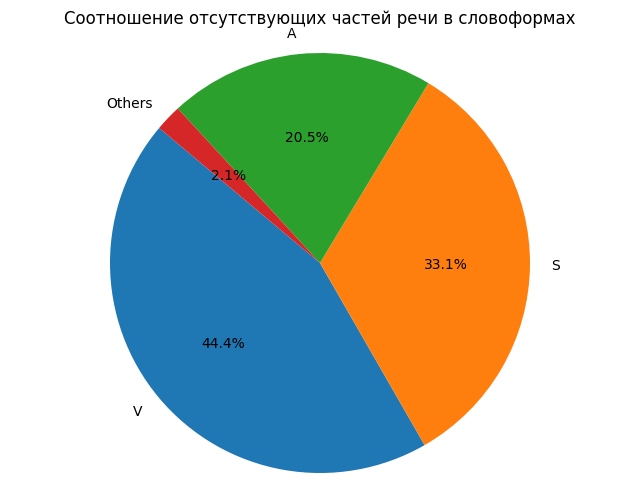

In [10]:
analyze_missing_words_from_dict(Dostoevskiy, lemmatized_Dostoevskiy)

Общее количество отсутствующих слов: 1129
Процент незнакомых слов: 8.28%
Наиболее частотная часть речи отсутствующих слов: S
Частота незнакомых слов:
Word
видзел        2
подвысоцки    2
веруеши       2
десятков      1
пузьно        1
готув         1
неласкен      1
видзен        1
мувишь        1
значи         1
Name: count, dtype: int64


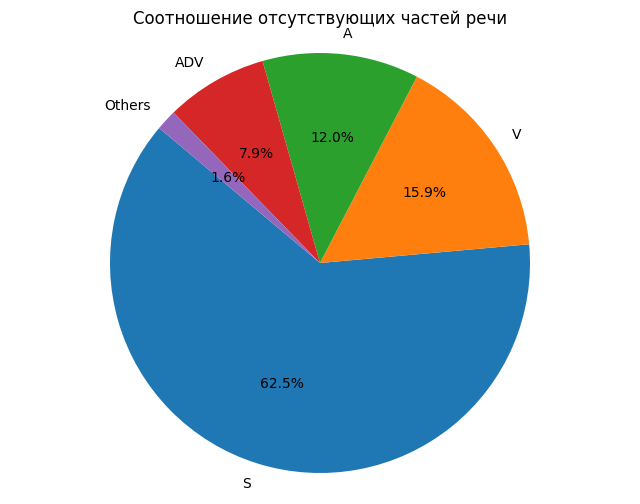

In [11]:
analyze_missing_words_from_text(lemmatized_Dostoevskiy)

# Пелевин

Общее количество отсутствующих словоформ: 3069788
Процент отсутствующих словоформ: 99.39%
Общее количество отсутствующих лемм: 373195
Процент отсутствующих лемм: 97.63%
Уменьшение разраженности при работе с леммами относительно словоформ: 1.75%
Наиболее частотная часть речи отсутствующих слов: V
Примеры отсутствующих лемм:
['отсыхающий', 'луковня', 'устояв', 'гидратировал', 'обмирщаема']


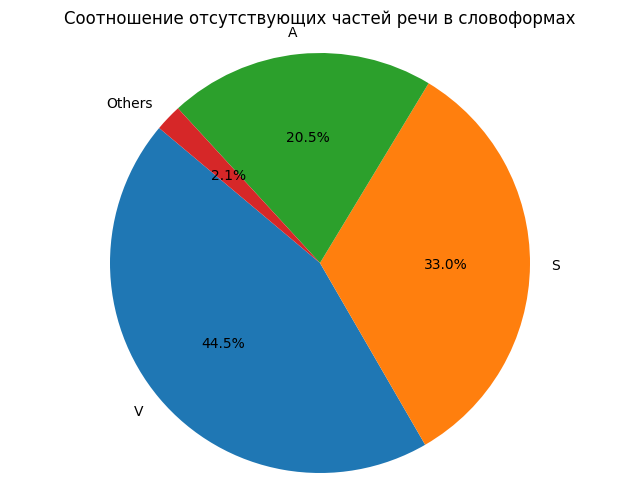

In [12]:
analyze_missing_words_from_dict(Pelevin, lemmatized_Pelevin)

Общее количество отсутствующих слов: 634
Процент незнакомых слов: 6.86%
Наиболее частотная часть речи отсутствующих слов: S
Частота незнакомых слов:
Word
вавилен           2
кэмела            2
во                1
насрать           1
пеже              1
позесьон          1
пацаками          1
рыночник          1
фейербаховская    1
обосрался         1
Name: count, dtype: int64


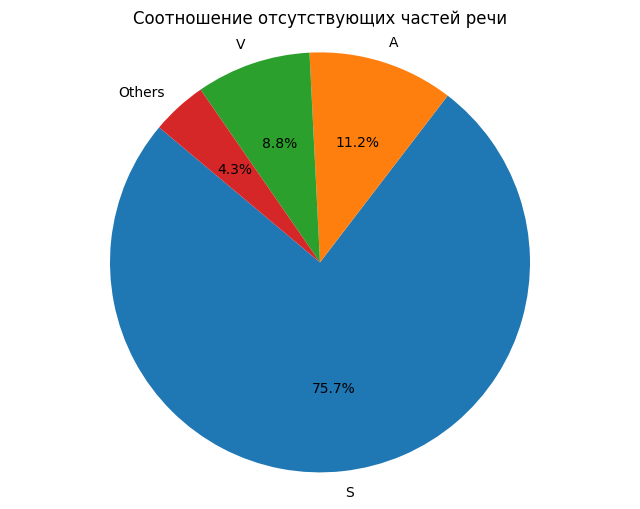

In [13]:
analyze_missing_words_from_text(lemmatized_Pelevin)

# Oxxxymiron

Общее количество отсутствующих словоформ: 3086782
Процент отсутствующих словоформ: 99.94%
Общее количество отсутствующих лемм: 380834
Процент отсутствующих лемм: 99.63%
Уменьшение разраженности при работе с леммами относительно словоформ: 0.31%
Наиболее частотная часть речи отсутствующих слов: V
Примеры отсутствующих лемм:
['плоскостопен', 'пенициллиновый', 'лобызавший', 'проперчился', 'распаривание']


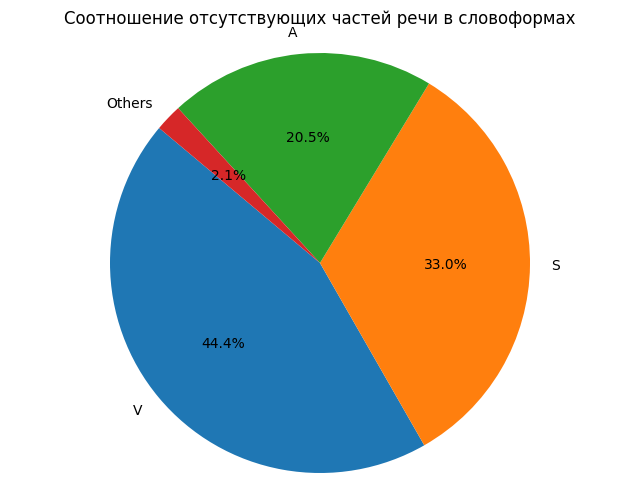

In [14]:
analyze_missing_words_from_dict(Oxxxymiron, lemmatized_Oxxxymiron)

Общее количество отсутствующих слов: 206
Процент незнакомых слов: 14.01%
Наиболее частотная часть речи отсутствующих слов: S
Частота незнакомых слов:
Word
говно          1
тентакли       1
оксимироном    1
подтанцовке    1
дэнсить        1
галата         1
букинга        1
лайв           1
заебался       1
епта           1
Name: count, dtype: int64


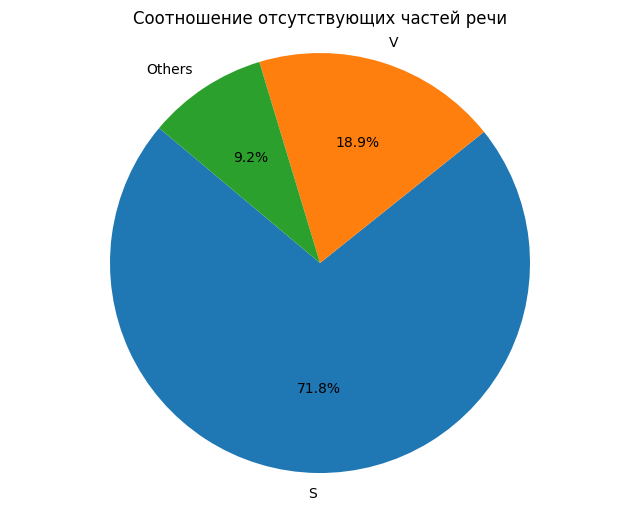

In [15]:
analyze_missing_words_from_text(lemmatized_Oxxxymiron)